In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calculate_test_statistic(test_metric, y_rep):
    return test_metric(y_rep, 0)

In [3]:
def calculate_p_value(test_metric, y, y_rep):
    test_statistic = calculate_test_statistic(test_metric, y_rep)
    return np.mean(test_statistic > test_metric(y))

In [4]:
def create_datasets(
    loc_true, scale_true, post_mu, post_scale, dataset_size, num_datasets
):
    y = np.random.normal(loc_true, scale_true, size=dataset_size)
    loc_post = np.random.normal(post_mu, scale=post_scale, size=num_datasets)
    y_rep = np.random.normal(
        loc_post, scale_true, size=(dataset_size, num_datasets)
    )
    return y, y_rep

### Overview 

Here we look at some properties of Bayesian p-values.

Note that a **single** p-value is calculated as followed:

1. Sample (or get given) a real dataset $y\sim \mathcal{N}(\mu_{true}, \sigma_{true})$ with unknown (in reality, but we know them here) parameters of size `dataset_size`.
2. Calculate the posterior the mean, $\mu$. We initially pretend it's a normal distribution centered at the true $\mu_{true}$.
3. Using the posterior over $\mu$ (which is our estimate of $\mu_{true}$) we create `num_datasets` replicate datasets by sampling many times from the posterior and then, for each posterior sample, sampling a replicate dataset of the same size as the original dataset.
4. For each replicate dataset, calculate a test statistic, here we use the min (but it doesn't really matter for this example).
5. Call the p-value the number of test statistics more (or less, it doesn't matter here) extreme than the actual min of $y$.

The above gets us a single p-value. To get the distribution of p-values we repeat the above `n_experiments` times.

We want to consider, initially, what happens as we vary $\sigma_{post}$ to the distribution of the p-values.

In [40]:
loc_true = 2
scale_true = 2
dataset_size = 250
num_datasets = 1000
n_experiments = 1000

In [41]:
p_values_scales = []
scales = [0.0001, 0.01, 1, 8, 32]
test_metric = np.min

for posterior_scale in scales:
    p_values = []
    for i in range(n_experiments):
        y, y_rep = create_datasets(
            loc_true,
            scale_true,
            loc_true,
            posterior_scale,
            dataset_size,
            num_datasets,
        )
        p_values.append(calculate_p_value(test_metric, y, y_rep))
    p_values_scales.append(p_values)

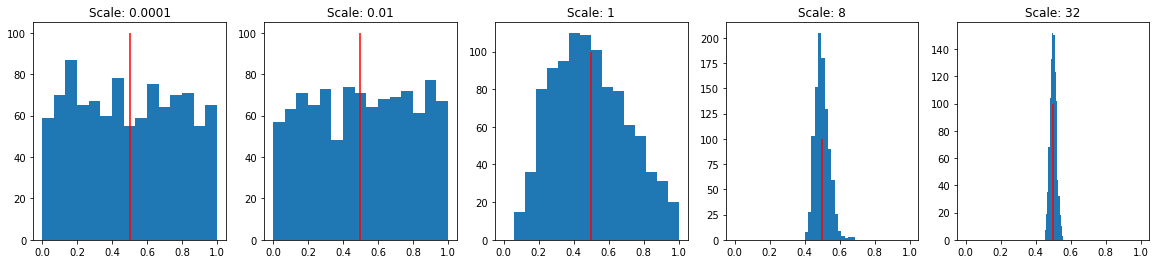

In [44]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharex=True)
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.hist(p_values_scales[i], bins=15)
    ax.set_title(f"Scale: {scales[i]}")
    ax.vlines(0.5, 0, 100, color="red")

We see that as we increase the variance in the posterior the p-value of tends to be increasingly centered at 0.5 with very small variance.

To understand why this is, it's helpful to plot some corresponding $y_{rep}$ datasets and the distribution of the test statistics for a single experiment. The rows of the plots correspond to 4 "regimes":

1. **Posterior centered at the true value with low variance:** here we produce replicate datasets that look like the real data. As such p-value is then uniformly distributed and so re-running the below cell will change the value, potentially significantly.
2. **Posterior centered at the true value with high variance:** here the replicate datasets we produce are all over the shop (as the posterior has high variance). This roughly has the effect of making half the test statistics smaller than the actual min of $y$ and the other half larger and so the p-value is centered around 0.5 (as we saw above).
3. **Posterior centered at a different (biased) value with low variance:** extreme (bad) p-value.
4. **Posterior centered at a different (biased) value with high variance:** depending on the interplay between the bias of and variance in the posterior mean we may get extreme (or not) p-values.

**Lesson:** Gelman says p-values around 0.5 are desirable (or rather, not extreme) but clearly this is conditional on having sufficiently low posterior variance. Put another way, getting an extreme p-value (close to 0 or 1) when the posterior variance is small is unlikely (tending to uniform as the posterior variance goes to 0 if the estimator isn't biased) and much more likely if the variance is small if the unless the posterior value is biased.

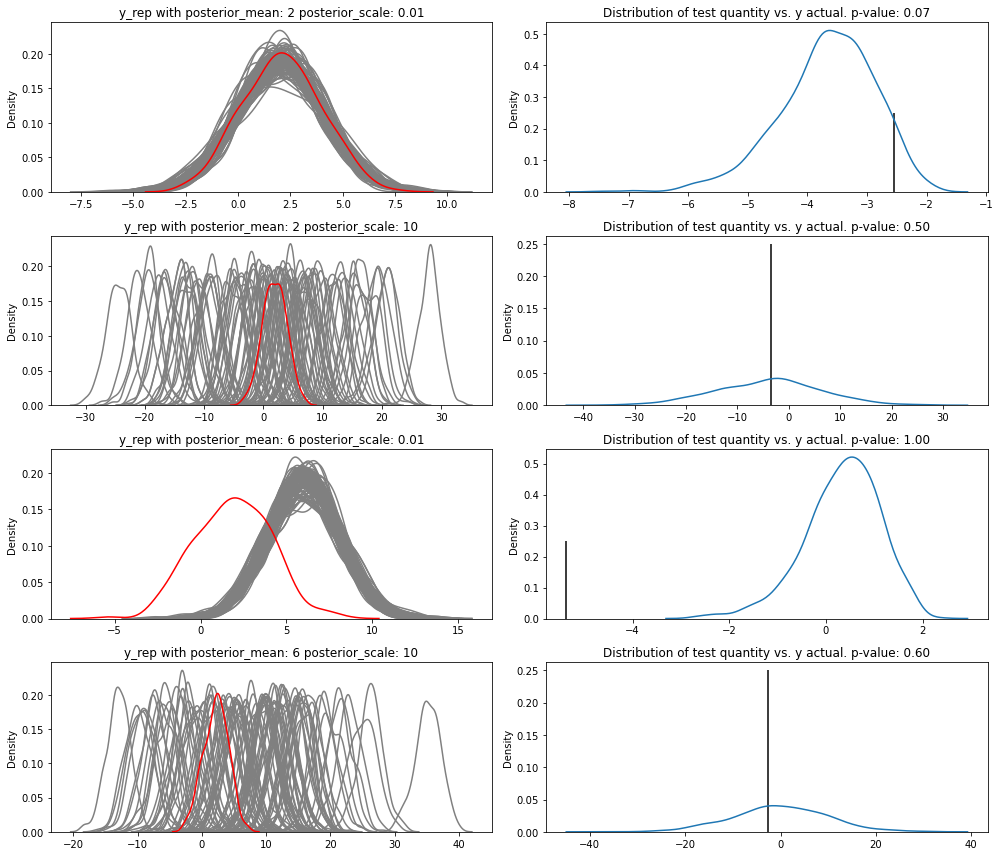

In [46]:
posterior_means = [2, 6]
posterior_scales = [1e-2, 10]

counter = 0
fig, ax = plt.subplots(4, 2, figsize=(14, 12))
ax = ax.ravel()

for posterior_mean in posterior_means:
    for posterior_scale in posterior_scales:

        y, y_rep = create_datasets(
            loc_true,
            scale_true,
            posterior_mean,
            posterior_scale,
            dataset_size,
            num_datasets,
        )
        test_statistic = calculate_test_statistic(test_metric, y_rep)
        p_value = calculate_p_value(test_metric, y, y_rep)

        for i in range(100):
            sns.kdeplot(
                y_rep[:, np.random.randint(n_experiments)],
                color="grey",
                ax=ax[2 * counter],
            )
        ax[2 * counter].set_title(
            f"y_rep with posterior_mean: {posterior_mean} posterior_scale: {posterior_scale}"
        )
        sns.kdeplot(y, color="red", ax=ax[2 * counter])
        sns.kdeplot(test_statistic, ax=ax[2 * counter + 1])
        ax[2 * counter + 1].vlines(test_metric(y), 0, 0.25)
        ax[2 * counter + 1].set_title(
            f"Distribution of test quantity vs. y actual. p-value: {p_value:.2f}"
        )
        plt.tight_layout()
        counter += 1